# Wrangling, preparation and learning Gaussian distribution's parameters for spherical codes

This notebook contains some data-wrangling codes. The goal is to extract from the dataset, trajectories under suitable forms to perform FPCA and distribution learning.

# Preambles

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
# sys.path.append("/Users/thinhhoang/Documents/anomaly-detection-ngsim")
sys.path.append("C:\\Users\\nxf67027\\Documents\\anomaly-detection-ngsim")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from seig import eig as eig

%matplotlib inline

# Loading dataset

In [3]:
df = pd.read_csv('../kalmaned2.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,...,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy,Vehicle_EKF_Accel,Vehicle_EKF_Theta,Vehicle_EKF_Velocity
0,0,0,1,270,569,1118847869000,51.164,112.878,6451136.708,1873294.084,...,19.89,0.00,5,0,0,0.0,0.0,0.352090,-0.000532,18.144384
1,1,1,1,271,569,1118847869100,51.153,114.878,6451138.053,1873292.603,...,19.89,0.00,5,0,0,0.0,0.0,0.606310,-0.000481,18.179593
2,2,2,1,272,569,1118847869200,51.143,116.878,6451139.397,1873291.122,...,19.89,0.00,5,0,0,0.0,0.0,0.662968,0.000942,18.265646
3,3,3,1,273,569,1118847869300,51.244,118.815,6451140.617,1873289.614,...,19.89,0.00,5,0,0,0.0,0.0,0.299653,0.001631,18.312187
4,4,4,1,274,569,1118847869400,51.234,120.814,6451141.961,1873288.133,...,19.89,1.07,5,0,0,0.0,0.0,0.289715,0.000712,18.325577


In [ ]:
from ngsim_processor import NGSIM_Processor as NGSIM

container_t = []
container_x = []
container_y = []
num_of_trajs = 200
traj_length = []

ngsim = NGSIM(df)
ngsim.set_patch(0.0, 75.0, 100.0, 2000.0) # see the notebook df_stats.py to see where these numbers come from

for i in range(num_of_trajs):
    t, x, y = ngsim.get_trajectory_random_in_patch_for_a_duration(30000) # the last patch coordinate (2000) is ignored.
    # we just create a dataset of trajectories, starting from local_X = 100ft, and lasts for 500s.
    container_t.append(t)
    container_x.append(x)
    container_y.append(y)
    traj_length.append(len(t))
    if i%50 == 0:
        print('Trajectory {:d} generated, length {:d}'.format(i, len(t)))

print('Process completed')

Without lengthening or trimming any trajectories, let's visualize the trajectories a little bit:

In [ ]:
plt.subplot(2,1,1)
for i in range(num_of_trajs):
    plt.plot(container_x[i])
plt.title('Lateral coordinates (X)')
plt.subplot(2,1,2)
for i in range(num_of_trajs):
    plt.plot(container_y[i])
plt.title('Longitudinal coordinates (Y)')
plt.tight_layout()

Zoom in on several "long" longitudinal trajectories 

In [ ]:
for i in range(num_of_trajs):
    traj_i = container_y[i]
    length_of_traj_i = len(traj_i)
    if length_of_traj_i > 250:
        plt.plot(container_y[i])

It's clear that both modes exhibit multimodal characteristics. Of course nothing prevents us from ignoring this fact and proceed on to performing FPCA. However, since the changepoints' distribution is still unknown, even if the local patterns are repeated, we ended up with completely different representation if we try to take the "global FPCA".

## Some further wranglings

"Zero-ifying" y at t = 0:

Also, put all longitudinal trajectories into a np array whose second dimension is the largest value of trajectory length.

In [ ]:
container_y_np = np.zeros((num_of_trajs, max([len(x) for x in container_y])))
for i in range(num_of_trajs):
    traj_i_converted_to_np = np.array(container_y[i])
    container_y_np[i,:len(container_y[i])] = traj_i_converted_to_np - traj_i_converted_to_np[0]

Replot the whole stuffs:

In [ ]:
for i in range(num_of_trajs):
    plt.plot(np.trim_zeros(container_y_np[i,]))

The time vector:

In [ ]:
container_t_np = np.array(container_t[0])
container_t_np -= container_t_np[0]

Wrangling x component:

In [ ]:
container_x_np = np.zeros((num_of_trajs, max([len(x) for x in container_x])))
for i in range(num_of_trajs):
    traj_i_converted_to_np = np.array(container_x[i])
    container_x_np[i,:len(container_x[i])] = traj_i_converted_to_np - traj_i_converted_to_np[0]

In [ ]:
for i in range(num_of_trajs):
    plt.plot(np.trim_zeros(container_x_np[i,]))

# Save data to Pickled file

Let's save the workspace to file so subsequent launches can be faster:

In [ ]:
import pickle

file_to_store = open("prepare_trajectories.pkl", "wb")
pickle.dump({'t': container_t_np, 'y': container_y_np, 'x': container_x_np }, file_to_store)
print('Data wrote to file')
file_to_store.close()


# Load data from Pickled file

To restore variables, run this code:

In [2]:
import pickle

with open('prepare_trajectories.pkl', 'rb') as handle:
    pkl_obj = pickle.load(handle)
    container_t_np = pkl_obj['t']
    container_x_np = pkl_obj['x']
    container_y_np = pkl_obj['y']
    print('Data loaded from file')

num_of_trajs = container_y_np.shape[0]

Data loaded from file


# Orientations

We will perform FPCA decomposition on the entire dataset, and check the representations of each trajectory.

The idea is to perform recognition of the mode first based on recent observations, then pick the corresponding basis, support and prior distribution (i.e., local FPCA). The other train of thought is to perform local decomposition of the signal at different scale, then rely on optimization to recover the entire signal. Contrary to the former process, the latter is indifferent to most recent observations.

# Global FPCA decomposition for Y component

In [3]:
import sklearn
import skfda

%matplotlib inline

 c:\Users\nxf67027\Anaconda3\envs\liberty\lib\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning:The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.


Convert the data to appropriate type for the skfda package

In [4]:
fdgrx = skfda.FDataGrid(container_x_np, np.arange(container_x_np.shape[1]))
fdgry = skfda.FDataGrid(container_y_np, np.arange(container_y_np.shape[1]))
# here we don't use the container_t_np vector since we don't want it to mess up the unit

In [5]:
# from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA

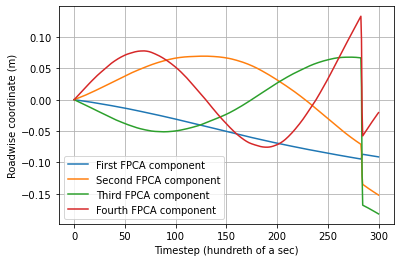

In [6]:
fpca_y = FPCA(n_components=4)
fpca_y.fit(fdgry)
fpca_y.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component'])
print('')

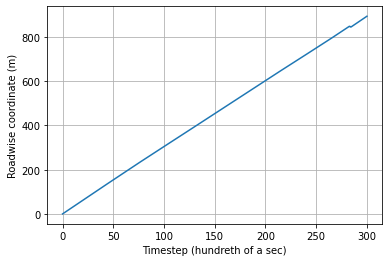

In [7]:
fpca_y.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_y = fpca_y.mean_.data_matrix.reshape((-1))

[0.89731514 0.07348648 0.02266406 0.00532613]


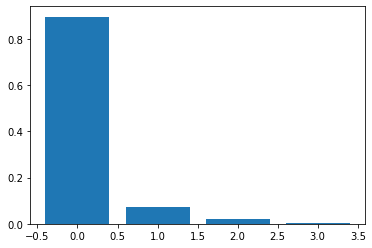

In [8]:
plt.bar(np.arange(4), fpca_y.explained_variance_ratio_)
print(fpca_y.explained_variance_ratio_)

# Global FPCA decomposition for X component

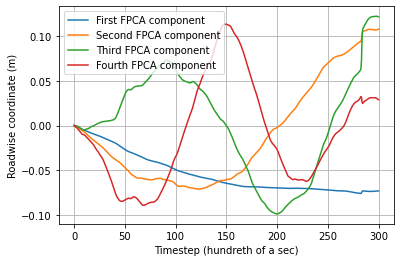

In [9]:
fpca_x = FPCA(n_components=4)
fpca_x.fit(fdgrx)
fpca_x.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component'])
print('')

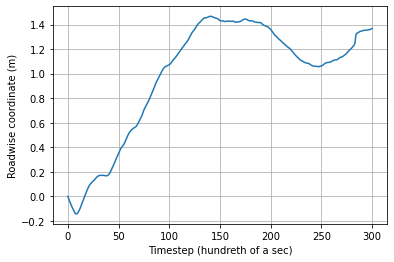

In [10]:
fpca_x.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_x = fpca_x.mean_.data_matrix.reshape((-1))

[0.91929363 0.04625759 0.01301754 0.00650374]


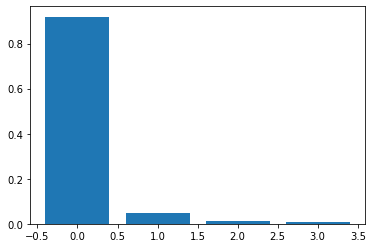

In [11]:
plt.bar(np.arange(4), fpca_x.explained_variance_ratio_)
print(fpca_x.explained_variance_ratio_)

# Trajectories decomposed into Karhunen-Loeve basis

Let's rephrase the basis in a more friendly form to work with:

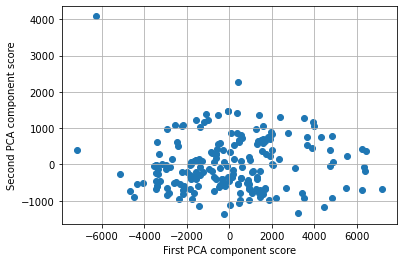

In [12]:
y_basis = fpca_y.components_.data_matrix.squeeze().transpose()
y_coeffs = np.matmul(container_y_np - mean_y, y_basis)
plt.scatter(y_coeffs[:,0], y_coeffs[:,1])
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

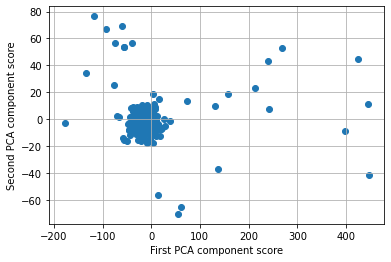

In [13]:
x_basis = fpca_x.components_.data_matrix.squeeze().transpose()
x_coeffs = np.matmul(container_x_np - mean_x, x_basis)
plt.scatter(x_coeffs[:,0], x_coeffs[:,1])
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

# Learn the distribution of representations

In [14]:
# Plotting helper function

import itertools
from scipy import linalg
import matplotlib as mpl
def plot_results(X, Y_, means, covariances, index, title):
    color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #plt.xlim(-3.0, 3.0)
    #plt.ylim(-3.0, 3.0)
    #plt.xticks(range(-3, 4))
    #plt.xticks(range(-3, 4))
    plt.xlim(X[:,0].min(), X[:,0].max())
    plt.ylim(X[:,1].min(), X[:,1].max())
    plt.gca().set_aspect('equal')
    plt.title(title)

 c:\Users\nxf67027\Anaconda3\envs\liberty\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


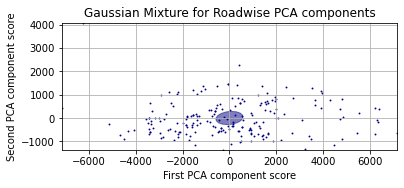

In [15]:
from sklearn.mixture import GaussianMixture
gm_y = GaussianMixture(n_components=1, random_state=0).fit(y_coeffs)
plot_results(y_coeffs, gm_y.predict(y_coeffs), gm_y.means_, gm_y.covariances_, 0, 'Gaussian Mixture for Roadwise PCA components')
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

 c:\Users\nxf67027\Anaconda3\envs\liberty\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


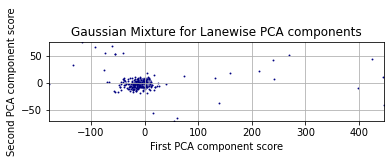

In [16]:
gm_x = GaussianMixture(n_components=1, random_state=0).fit(x_coeffs)
plot_results(x_coeffs, gm_x.predict(x_coeffs), gm_x.means_, gm_x.covariances_, 0, 'Gaussian Mixture for Lanewise PCA components')
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

We pickle these Gaussian distribution parameters to a pickle file:

In [17]:
pickle.dump({
    'cov': gm_y.covariances_,
    'mu': gm_y.means_,
    'mean_curve': mean_y,
    'coeffs': y_coeffs,
    'basis': y_basis
}, open( "y.pkl", "wb" ) )

print('Y component Gaussian Mixture dumped to y.pkl')

pickle.dump({
    'cov': gm_x.covariances_,
    'mu': gm_x.means_,
    'mean_curve': mean_x,
    'coeffs': x_coeffs,
    'basis': x_basis
}, open( "x.pkl", "wb" ) )

print('X component Gaussian Mixture dumped to x.pkl')

Y component Gaussian Mixture dumped to y.pkl
X component Gaussian Mixture dumped to x.pkl
